# AB тестирование

## A/A тест для проверки

### Поготовка данных
Изучим данные, уберем выбросы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
def prepare_data(filename):
    data = pd.read_csv(filename, names=["id", "clicks", "in_group"])
    print(data.head())

    # Смотрим персентили
    print(f"100 percentile: {np.percentile(data['clicks'], 100)}")
    perc_95 = np.percentile(data['clicks'], 95)
    print(f"95 percentile: {perc_95}")
    print(f"85 percentile: {np.percentile(data['clicks'], 85)}")

    # Фильтруем данные по 95 персентилю, таким образом убираем выбросы
    data = data.loc[data['clicks'] <= perc_95]

    # Гистограмма
    plt.figure(figsize=(16, 9))
    plt.title('Гистограмма количества кликов')
    plt.hist(data['clicks'], density=True)
    plt.xlabel('Количество кликов')
    plt.ylabel('Количество сессий')  # Поскольку данные за несколько дней, на каждый день будет отдельный ряд
    plt.legend()
    plt.show()

    data['in_group'].value_counts().plot(kind='bar')
    plt.title('Гистограмма количества людей в каждой группе')

    return data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


             id  clicks  in_group
0  577919324980       4     False
1  583907240721       2     False
2  561491948916       2      True
3  584748748548       1     False
4  539721118331       1      True
100 percentile: 3054.0
95 percentile: 10.0
85 percentile: 5.0


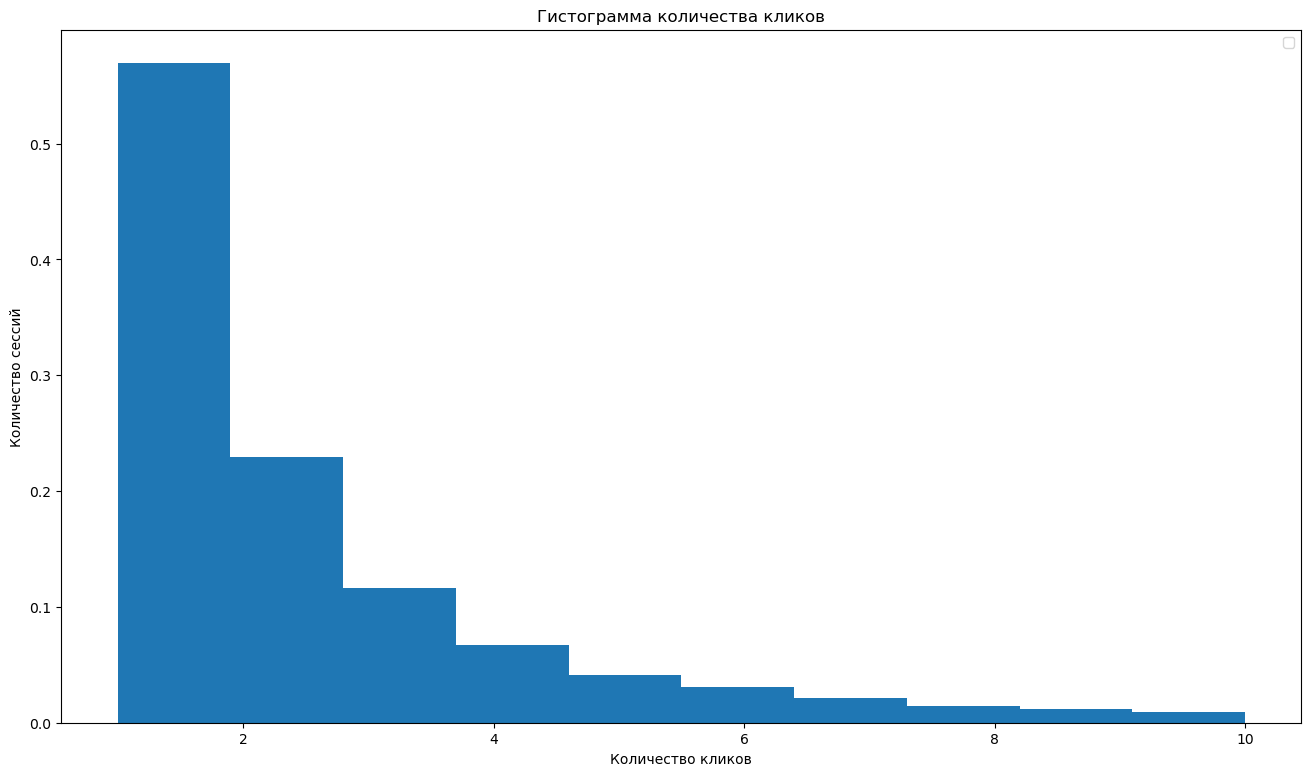

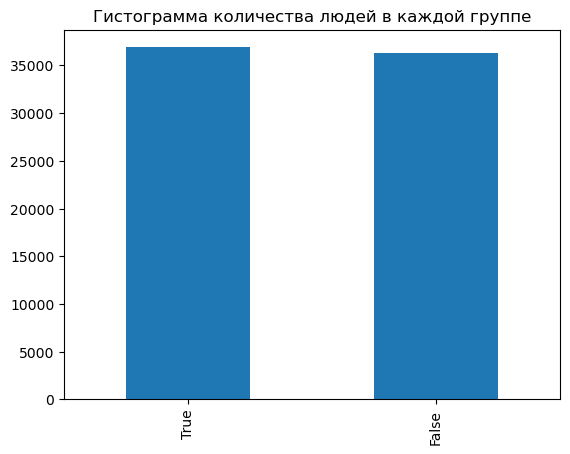

In [82]:
no_exp_data = prepare_data('ab_no_exp_data.csv')

# Нулевая гипотеза
Выдвинем нулевую гипотезу $H_0$ о том, что среднее количество кликов в двух группах равны.
И альтернативную $H_1$, что они отличаются.
Для проверки будем использовать Bootstrap.

In [ ]:
!pip install bootstrapped

In [33]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [88]:
def bootstrap(data):
    # Делим данные на тестовую и контрольную группу
    test = data[data['in_group']]['clicks'].values
    ctrl = data[data['in_group'] == False]['clicks'].values  # == False logical expression to create array

    # Запускаем Bootstrap и сохраняем результаты каждой итерации
    boot_results = bs.bootstrap_ab(test=test, ctrl=ctrl, stat_func=bs_stats.mean, compare_func=bs_compare.difference,
                                   return_distribution=True)
    print(f'Header результатов bootstrap: {boot_results[:10]}')

    borders = np.percentile(boot_results, [2.5, 97.5])
    print('Уровень значимости: 0.05')
    print(f'Границы доверительных интервалов, определенных как 2.5 и 97.5 персентиль соответсвенно {borders}')

    plt.figure(figsize=(12, 6))
    plt.title('Нормированная гистограмма для разностей средних')
    plt.hist(boot_results, density=True)
    plt.vlines(0, ymin=0, ymax=25, linestyles='--', colors='red')
    plt.vlines(borders, ymin=0, ymax=25, linestyles='--', colors='gray', label='95% доверительный интервал')
    plt.legend()
    plt.show()

Header результатов bootstrap: [ 0.01999522  0.00123697  0.01422043  0.00369287 -0.02345783  0.02387441
 -0.00061642  0.02129762  0.0080844  -0.01090538]
Уровень значимости: 0.05
Границы доверительных интервалов, определенных как 2.5 и 97.5 персентиль соответсвенно [-0.01960853  0.03490945]


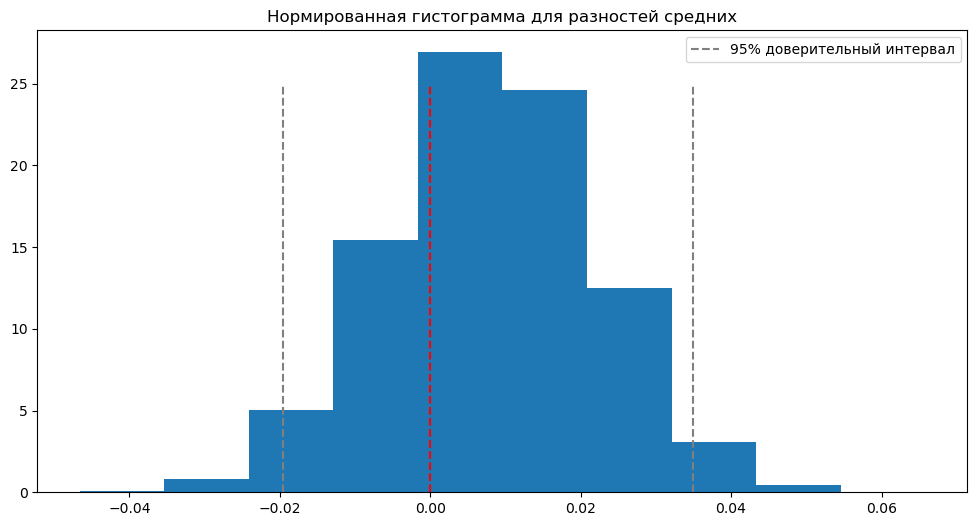

In [89]:
bootstrap(no_exp_data)

## A/B тест
Проделаем те же самые шаги, но на данных, где действительно проводился эксперимент

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


             id  clicks  in_group
0  488919586599       2      True
1  465184427021       1      True
2  454318518857       3     False
3  537597970950       2     False
4  576401480975       1      True
100 percentile: 473.0
95 percentile: 10.0
85 percentile: 5.0


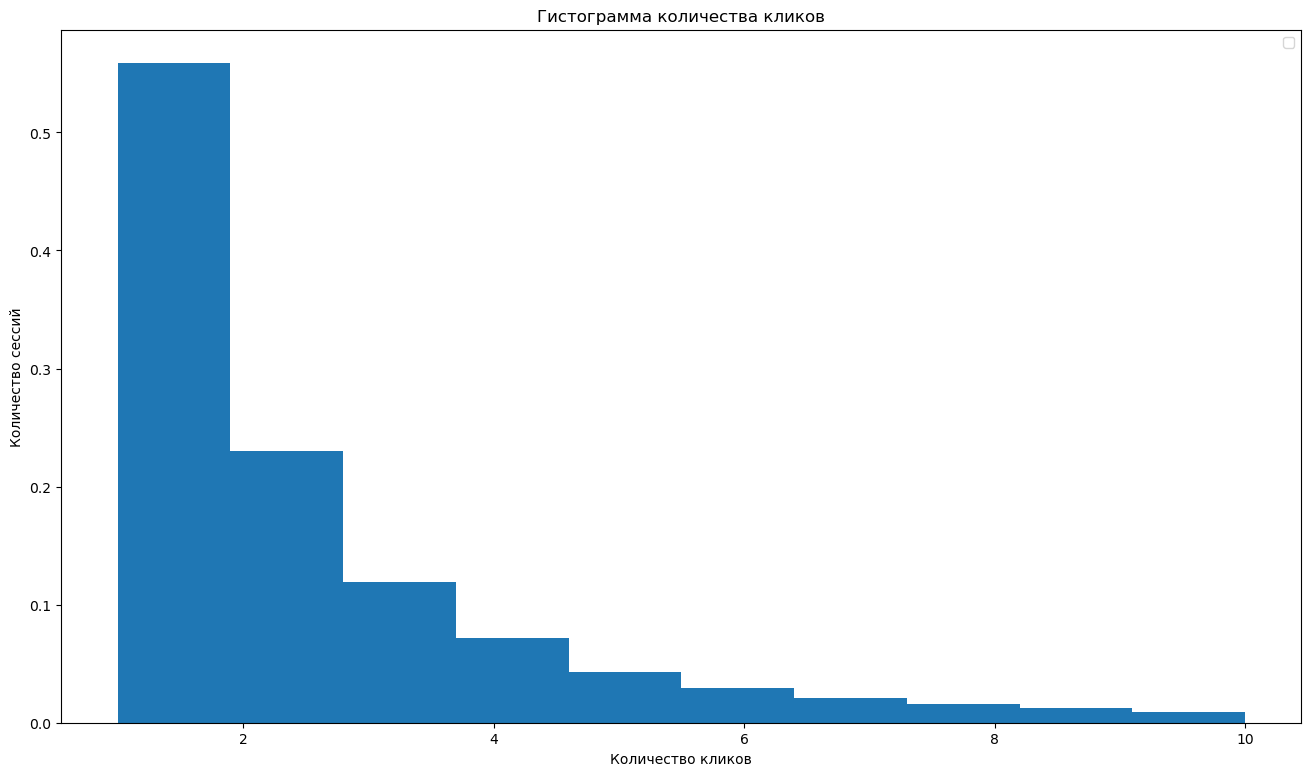

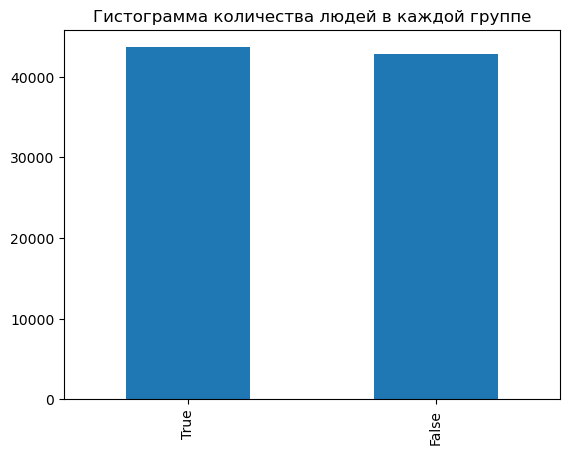

In [83]:
exp_data = prepare_data('ab_exp_data.csv')

Header результатов bootstrap: [0.03869944 0.05871258 0.05962461 0.0741147  0.03116694 0.063034
 0.05333346 0.0213832  0.07098906 0.03676887]
Уровень значимости: 0.05
Границы доверительных интервалов, определенных как 2.5 и 97.5 персентиль соответсвенно [0.02793374 0.07876195]


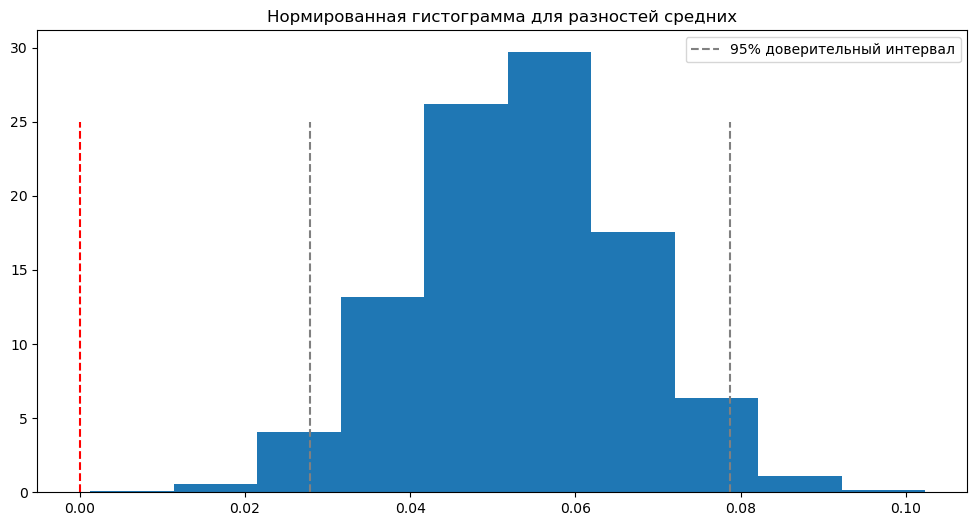

In [80]:
bootstrap(exp_data)